In [1]:
# Import Library
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import random
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score
from pathlib import Path

import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.autograd import Variable

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu") 

CUDA is available!  Training on GPU ...


In [3]:
TRAIN="C:/Users/Juengtaweepatch/Machine Learning/Data/train"
TEST="C:/Users/Juengtaweepatch/Machine Learning/Data/test"

In [4]:
print(TRAIN)
print(TEST)

C:/Users/Juengtaweepatch/Machine Learning/Data/train
C:/Users/Juengtaweepatch/Machine Learning/Data/test


In [5]:
print("Train set:\n---------------------------------------------------")
PNEUMONIA_TRAIN = len(os.listdir(os.path.join(TRAIN, 'PNEUMONIA')))
NORMAL_TRAIN= len(os.listdir(os.path.join(TRAIN, 'NORMAL')))
COVID19_TRAIN= len(os.listdir(os.path.join(TRAIN, 'COVID19')))
print(f"PNEUMONIA_TRAIN={PNEUMONIA_TRAIN}",f"\nNORMAL_TRAIN={NORMAL_TRAIN}",f"\nCOVID19_TRAIN={COVID19_TRAIN}")


print("\nTest set:\n----------------------------------------------------")
PNEUMONIA_TEST = len(os.listdir(os.path.join(TEST, 'PNEUMONIA')))
NORMAL_TEST= len(os.listdir(os.path.join(TEST, 'NORMAL')))
COVID19_TEST= len(os.listdir(os.path.join(TEST, 'COVID19')))
print(f"PNEUMONIA_TEST={PNEUMONIA_TEST}",f"\nNORMAL_TEST={NORMAL_TEST}",f"\nCOVID19_TEST={COVID19_TEST}")

Train set:
---------------------------------------------------
PNEUMONIA_TRAIN=3418 
NORMAL_TRAIN=1266 
COVID19_TRAIN=460

Test set:
----------------------------------------------------
PNEUMONIA_TEST=855 
NORMAL_TEST=317 
COVID19_TEST=116


In [6]:
# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

In [7]:
# choose the training and test datasets
train_data = datasets.ImageFolder(TRAIN, transform=train_transforms)
test_data = datasets.ImageFolder(TEST, transform=test_transforms)
print(train_data.class_to_idx)
print(test_data.class_to_idx)

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [8]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16
# learning rate
LR = 0.001

In [9]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers)
images,labels=next(iter(train_loader))
images.shape,labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [10]:
classes = ['COVID19','NORMAL','PNEUMONIA']
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])


def denormalize(image):
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
  image = torch.clamp(image,0,1)
  return image

# helper function to un-normalize and display an image
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)

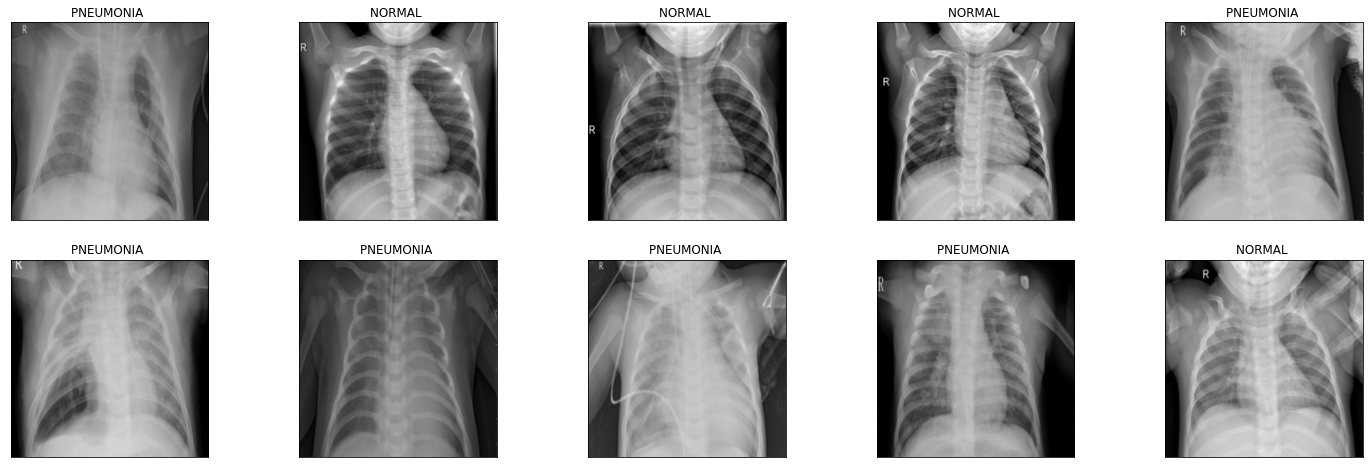

In [11]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
 # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ".format( classes[labels[idx]]))

In [12]:
model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [13]:
from collections import OrderedDict
from torch import optim

In [14]:
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 512)),
    ('relu', nn.LeakyReLU()),
    ('fc2', nn.Linear(512, 3)),
    ('output', nn.LogSoftmax(dim=1))
]))


model.classifier = classifier

# Modeli GPU'ya aktarma

model.to(device)

criterion = nn.NLLLoss().to(device)
optimizer = optim.Adam(model.classifier.parameters(), lr=LR)

In [15]:
from tqdm import tqdm
import time

In [18]:
def train_model(model, optimizer, n_epochs, criterion):
    start_time = time.time()
    if train_on_gpu:
        model.cuda()
    for epoch in range(1, n_epochs+1):
        epoch_time = time.time()
        epoch_loss = 0
        correct = 0
        total=0
        print("Epoch {} / {}".format(epoch, n_epochs))
        model.train()
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # zeroed grads
            outputs = model(inputs) # forward pass
            loss = criterion(outputs, labels) # softmax + cross entropy
            loss.backward() # back pass
            optimizer.step() # updated params
            epoch_loss += loss.item() # train loss
            _, pred = torch.max(outputs, dim=1)
            correct += (pred.cpu() == labels.cpu()).sum().item()
            total += labels.shape[0]
        acc = correct / total
        
        model.eval()
        a=0
        pred_val=0
        correct_val=0
        total_val=0
        with torch.no_grad():
            for inp_val, lab_val in test_loader:
                inp_val = inp_val.to(device)
                lab_val = lab_val.to(device)
                out_val = model(inp_val)
                loss_val = criterion(out_val, lab_val)
                a += loss_val.item()
                _, pred_val = torch.max(out_val, dim=1)
                correct_val += (pred_val.cpu()==lab_val.cpu()).sum().item()
                total_val += lab_val.shape[0]
            acc_val = correct_val / total_val
        epoch_time2 = time.time()
        print("Duration: {:.0f}s, Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}"
              .format(epoch_time2-epoch_time, epoch_loss/len(labels), acc, a/len(lab_val), acc_val))
    end_time = time.time()
    print("Total Time:{:.0f}s".format(end_time-start_time))

    
train_model(model, optimizer,10, criterion)

Epoch 1 / 10
Duration: 159s, Train Loss: 9.2979, Train Acc: 0.9141, Val Loss: 1.5514, Val Acc: 0.9363
Epoch 2 / 10
Duration: 161s, Train Loss: 7.5154, Train Acc: 0.9269, Val Loss: 1.9707, Val Acc: 0.9301
Epoch 3 / 10
Duration: 160s, Train Loss: 6.4106, Train Acc: 0.9370, Val Loss: 1.5967, Val Acc: 0.9394
Epoch 4 / 10
Duration: 162s, Train Loss: 7.2147, Train Acc: 0.9349, Val Loss: 1.4293, Val Acc: 0.9495
Epoch 5 / 10
Duration: 159s, Train Loss: 6.5463, Train Acc: 0.9393, Val Loss: 1.4284, Val Acc: 0.9526
Epoch 6 / 10
Duration: 159s, Train Loss: 6.9527, Train Acc: 0.9360, Val Loss: 1.7539, Val Acc: 0.9387
Epoch 7 / 10
Duration: 160s, Train Loss: 5.4339, Train Acc: 0.9506, Val Loss: 1.2604, Val Acc: 0.9542
Epoch 8 / 10
Duration: 160s, Train Loss: 6.1374, Train Acc: 0.9411, Val Loss: 1.3361, Val Acc: 0.9550
Epoch 9 / 10
Duration: 160s, Train Loss: 5.5861, Train Acc: 0.9467, Val Loss: 1.4140, Val Acc: 0.9519
Epoch 10 / 10
Duration: 159s, Train Loss: 4.5323, Train Acc: 0.9566, Val Loss: 1.2

In [22]:
def test_model(model, test_data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy of the network on the test images: {float(correct)/float(total)*100:.4f}")

test_model(model, test_loader)

Accuracy of the network on the test images: 95.2640


In [27]:
nb_classes = 3

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[113.,   0.,   3.],
        [  1., 289.,  27.],
        [  0.,  30., 825.]])


In [38]:
# Per-class accuracy
class_accuracy=100*confusion_matrix.diagonal()/confusion_matrix.sum(1)
print(class_accuracy)
print("COVID-19 class accuracy: ", class_accuracy[0])
print("Normal class accuracy: ", class_accuracy[1])
print("Pneumonia class accuracy: ", class_accuracy[2])

[97.4137931  91.16719243 96.49122807]
COVID-19 class accuracy:  97.41379310344827
Normal class accuracy:  91.16719242902208
Pneumonia class accuracy:  96.49122807017544


In [36]:
import pandas as pd
import seaborn as sns

''

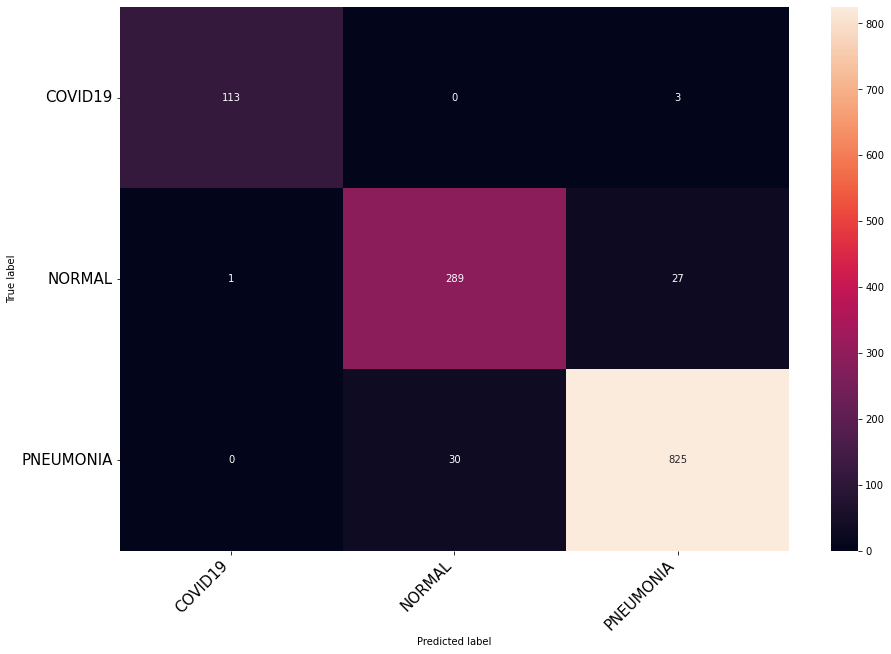

In [37]:
nb_classes = 3
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = train_data.class_to_idx  #list(label2class.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;